In [1]:
# IMPORT STUFF
from scipy.io import readsav
import netCDF4 as nc
import numpy as np
import os
import glob
import time
import matplotlib.pyplot as pl

In [252]:
import os

In [253]:
os.environ.get('OCSSWROOT')

'/accounts/ekarakoy/ocssw/'

In [2]:
# DATA STUFF
dataDir = '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/SWF/DATA/L2_L3/GLOBAL/StandardRun/'
fname = 'S2003196.L3b_DAY_SU4.nc'
fp = os.path.join(dataDir,fname)
# mask stuff
regMaskDirs = '/accounts/ekarakoy/idl/hdf/'
maskList = glob.glob(os.path.join(regMaskDirs,'global*.idl'))

In [254]:
maskList

['/accounts/ekarakoy/idl/hdf/global_bin_meso_9km.idl',
 '/accounts/ekarakoy/idl/hdf/global_bin_eutr_9km.idl',
 '/accounts/ekarakoy/idl/hdf/global_bin_regions_9km.idl',
 '/accounts/ekarakoy/idl/hdf/global_bin_deep_9km.idl',
 '/accounts/ekarakoy/idl/hdf/global_bin_olig_9km.idl']

In [258]:
a={}
a = readsav('/accounts/ekarakoy/idl/hdf/global_bin_regions_9km.idl',idict=a,
            python_dict=True)

In [261]:
b={}
b=readsav('/accounts/ekarakoy/idl/hdf/global_bin_meso_9km.idl',idict=a,
            python_dict=True)

In [262]:
b

{'deep': array([  64358,   64359,   64360, ..., 5940419, 5940420, 5940421], dtype=int32),
 'eutr': array([  58806,   58807,   59646, ..., 5922499, 5923429, 5923431], dtype=int32),
 'meso': array([  58808,   59645,   59650, ..., 5923428, 5923430, 5923432], dtype=int32),
 'olig': array([  80449,  103579,  122363, ..., 5864416, 5905357, 5919981], dtype=int32)}

In [260]:
for key,val in a.items():
    print("%s: %s" %(key, np.array_equal(a[key],maskDict[key])

deep has 3741734 bins
olig has 1096991 bins
eutr has 240591 bins
meso has 2827552 bins


In [255]:
t_start = time.time()
# initialize dictionary to contain mask
maskDict = {}
for maskPath in maskList:
    maskDict = readsav(maskPath,idict=maskDict,python_dict=True)
t_elapsed = time.time() - t_start
print('time taken: %.3f sec.' % t_elapsed)

time taken: 0.029 sec.


In [256]:
for key,val in maskDict.items():
    print("%s has %s bins" % (key,val.size))

eutr has 240591 bins
deep has 3741734 bins
olig has 1096991 bins
meso has 2827552 bins


In [5]:
ds = nc.Dataset(fp)

In [6]:
gpv = ds.groups['level-3_binned_data'].variables

In [7]:
bin_num_sat = gpv['BinList'][:]['bin_num']
wts = gpv['BinList'][:]['weights']

In [8]:
oligMask = np.in1d(bin_num_sat, maskDict['olig'])
eutrMask = np.in1d(bin_num_sat, maskDict['eutr'])
deepMask = np.in1d(bin_num_sat, maskDict['deep'])
mesoMask = np.in1d(bin_num_sat, maskDict['meso'])

In [267]:
rrs_unc_412.shape

(344688,)

In [268]:
print(oligMask.sum())
print(oligMask.size)

93130
344688


In [9]:
rrs_unc_412 = gpv['Rrs_unc_412'][:]['sum']/wts

In [10]:
def GetDistrib(data,bins=None): 
    if not bins:
        bins='auto'
    counts,edges = np.histogram(data,density=True,bins=bins)
    widths = np.diff(edges)
    centers = (edges[:-1]+edges[1:]) / 2
    return counts, centers, widths

In [319]:
np.sum(np.logical_not(np.logical_not(np.logical_not(oligMask,eutrMask),deepMask),mesoMask))

251558

In [166]:
def hdiByProb(x, binWidth=np.array([False]), credMass=0.95):
    ''' Computes HDI from pmf.
        x is probability (sum to 1) or counts.
       if counts, bin width should also be passed'''
    hdiDict = {}
    if binWidth.any():
        x = x * binWidth
    # reverse sort freq data
    scx = np.sort(x)[::-1]
    # reverse sort data idx
    scxi = np.argsort(x)[::-1]
    # compute cdf
    scxcsm = np.cumsum(scx)
    # get idx where cdf first matches or is greater than credMass
    # this gives the lower bound of the HDI
    # 0 is automatically the higher bound of the HDI
    cumIdxMax = np.argwhere(scxcsm>=credMass).min()
    cumMedIdx = np.argwhere(scxcsm<=0.5).max()
    # get idx of HDI lowerbound  (scx and  scxcsm have same index base)
    hdiMinIdx = scxi[cumIdxMax]
    medIdx = scxi[cumMedIdx]
    # though note necessarily useful for plotting,
    # get upper bound of hdiMaxIdx
    hdiMaxIdx = scxi[0]
    hdiMax,hdiMin = cx[hdiMaxIdx],cx[hdiMinIdx]
    hdiDict['hdiMin'] = hdiMin
    hdiDict['hdiMax'] = hdiMax
    hdiDict['hdiMaxIdx'] = hdiMaxIdx
    hdiDict['hdiIndices'] = np.argwhere(cx>=hdiMin)
    hdiDict['credMass'] = credMass
    hdiDict['medIdx'] = medIdx
    return hdiDict

In [315]:
def PlotDist(data,centers,widths,axh, **kwargs):
    bar = kwargs.pop('bar', False)
    datacolor = kwargs.pop('datacolor',None)
    edgecolor='black'
    if datacolor:
        edgecolor = datacolor
    dataname = kwargs.pop('dataname',None)
    xlim = kwargs.pop('xlim', None)
    hdiDict = kwargs.pop('hdiDict', None)
    hdicolor = kwargs.pop('hdicolor','black')
    axh.bar(centers,data,align='center',width=widths,color=datacolor,
           edgecolor=edgecolor, label=dataname)
    if xlim:
        axh.set_xlim(xlim)
    ylim = (0,data.max()*1.1) # give the hist a 5% clearance)
    axh.set_ylim(ylim)
    if hdiDict:
        wtdMeanX = np.sum(data*centers/data.sum())
        hdiMinX = centers[hdiDict['hdiIndices'].min()]
        hdiMaxX = centers[hdiDict['hdiIndices'].max()]
        hdiIdx = hdiDict['hdiIndices']
        axh.bar(centers[hdiIdx],data[hdiIdx],width=widths[hdiIdx],
               color=hdicolor, edgecolor=hdicolor, align='center',
               label='%.2f%% HDI (%.1e - %.1e)' % (hdiDict['credMass'],
                                                   centers[hdiIdx].min(),
                                                   centers[hdiIdx].max())
                                                   #hdiMinX, hdiMaxX),
               )
        yminMode = data[hdiDict['hdiMaxIdx']] / ylim[1]
        axh.axvline(x=centers[hdiDict['hdiMaxIdx']], ymin=yminMode,
                    color='black', linewidth=2, linestyle='--',
                    label = 'mode = %.1e' % centers[hdiDict['hdiMaxIdx']])
        axh.axvline(x=wtdMeanX, color=hdicolor, linewidth=2, linestyle='--',
                   label='weighted mean = %.1e' % wtdMeanX )
        yminMedian = data[hdiDict['medIdx']] / ylim[1]
        axh.axvline(x=centers[hdiDict['medIdx']],ymin=yminMedian,
                    color='black', linewidth=2,
                    label='median = %.1e' % centers[hdiDict['medIdx']])    
        axh.legend(loc='best')

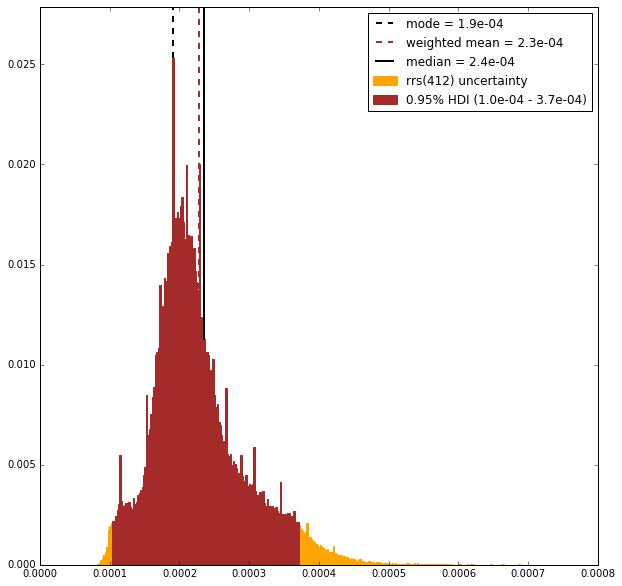

In [316]:
counts,centers,widths = GetDistrib(rrs_unc_412)
cx = counts*widths
hdi_dict = hdiByProb(counts,binWidth=widths,credMass=0.95)
f = pl.figure(figsize=(10,10))
ax = f.add_subplot(111)
PlotDist(cx,centers,widths,ax,xlim=(0,8e-4),hdiDict=hdi_dict,
         dataname='rrs(412) uncertainty',hdicolor='brown',datacolor='orange')

In [277]:
pl.axvline()

dict_keys(['hdiMaxIdx', 'medIdx', 'credMass', 'hdiIndices', 'hdiMax', 'hdiMin'])

In [285]:
lo,hi=np.percentile(rrs_unc_412,(2.5,97.5))
lo2,hi2 = centers[hdi_dict['hdiIndices'].min()],centers[hdi_dict['hdiIndices'].max()]
print("hdi = (%.1e - %.1e)" %(lo,hi))
print("hdi = (%.1e - %.1e)" % (lo2,hi2))

hdi = (1.2e-04 - 3.9e-04)
hdi = (1.0e-04 - 3.7e-04)


In [251]:
from auxiliary import GetHDI, PlotDist

In [135]:
pl.show()

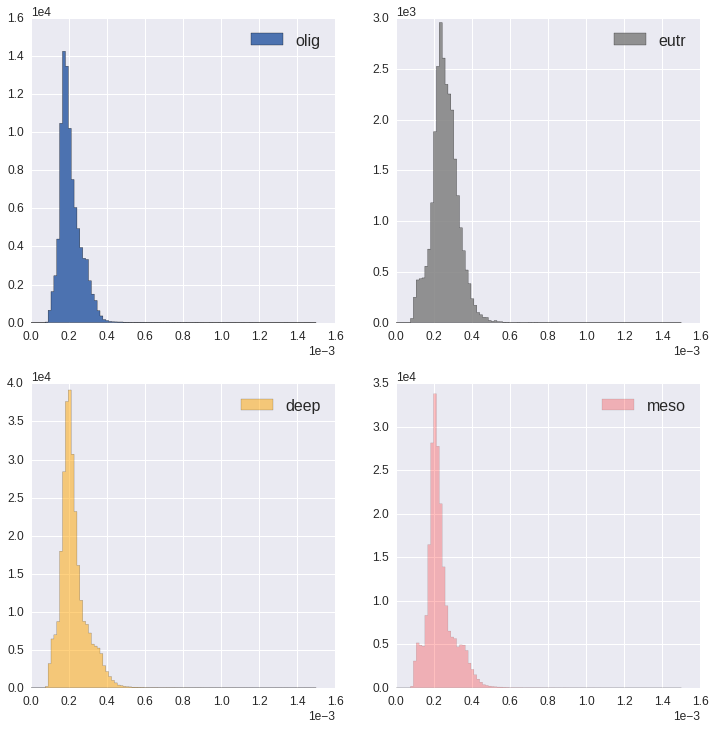

In [79]:
from matplotlib.pylab import rcParams
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12
fig=pl.figure(figsize=(12,12))
xbins=np.linspace(0,0.0015,num=100)
ax = fig.add_subplot(221) 
ax.hist(rrs_unc_412[oligMask], bins=xbins,histtype='stepfilled',label='olig');
ax.ticklabel_format(style='sci',scilimits=(-2,3),axis='both')
pl.legend(loc='best',fontsize=16);
ax = fig.add_subplot(222)
ax.hist(rrs_unc_412[eutrMask],color='gray', bins=xbins,histtype='stepfilled',alpha=0.85,
       label='eutr');
ax.ticklabel_format(style='sci',scilimits=(-2,3),axis='both')
pl.legend(loc='best',fontsize=16);
ax = fig.add_subplot(223)
ax.hist(rrs_unc_412[deepMask],color='orange',bins=xbins,histtype='stepfilled',alpha=0.5,
       label='deep');
ax.ticklabel_format(style='sci',scilimits=(-2,3),axis='both')
pl.legend(loc='best',fontsize=16);
ax=fig.add_subplot(224)
ax.hist(rrs_unc_412[mesoMask],color='red',bins=xbins,histtype='stepfilled',alpha=0.25,
       label='meso');
ax.ticklabel_format(style='sci',scilimits=(-2,3),axis='both')
pl.legend(loc='best',fontsize=16);

In [ ]:
enumerate()